<a href="https://colab.research.google.com/github/juliorodrigues07/LH_CD_JULIORODRIGUES/blob/extras/notebooks/3_ml_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports, export directories and preprocessed dataset**

In [2]:
!pip install -U kaleido
import pandas as pd
import gdown
from warnings import filterwarnings
from os.path import isdir
from os import getcwd
from os import mkdir


filterwarnings('ignore', category=DeprecationWarning)
filterwarnings('ignore', category=FutureWarning)

# Export directories
if not isdir(f'{getcwd()}/../plots'):
    mkdir(f'{getcwd()}/../plots')
if not isdir(f'{getcwd()}/../models'):
    mkdir(f'{getcwd()}/../models')
if not isdir(f'{getcwd()}/../datasets'):
    mkdir(f'{getcwd()}/../datasets')

dataset_file = "preprocessed.parquet"
file_id = '1KrqLaStIHwSq6xFCHtt0wcMn0F9ImaO4'
gdown.download(f'https://drive.google.com/uc?id={file_id}', dataset_file)

dataset = pd.read_parquet(dataset_file)

Downloading...
From: https://drive.google.com/uc?id=1KrqLaStIHwSq6xFCHtt0wcMn0F9ImaO4
To: /content/preprocessed.parquet
100%|██████████| 527k/527k [00:00<00:00, 75.3MB/s]


# **1. First impressions with different models**

- _Disclaimer_: All the models evaluation is done with cross validation (5-folds).


In [3]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


fitting = dataset.copy()
model_features = fitting.drop(['Price'], axis='columns')
model_classes = fitting['Price']

scaler = StandardScaler()

lr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', LinearRegression())
])

knn_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', KNeighborsRegressor(n_jobs=-1))
])

xgb_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', XGBRegressor(n_jobs=-1))
])

lgbm_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', LGBMRegressor(n_jobs=-1, verbose=-1))
])

hist_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', HistGradientBoostingRegressor())
])

pipelines = {
    'Linear Regression': lr_pipeline,
    'KNN': knn_pipeline,
    'XGBoost': xgb_pipeline,
    'LightGBM': lgbm_pipeline,
    'HistGB': hist_pipeline
}

mean_results, std_results = pd.DataFrame(), pd.DataFrame()
mean_results['Metric'] = std_results['Metric'] = ['R²', 'MAE', 'RMSE']

# 5-fold cross-validation
for key in pipelines:
    scores = cross_validate(
        estimator=pipelines[key],
        X=model_features,
        y=model_classes,
        cv=KFold(n_splits=5, shuffle=True),
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        n_jobs=-1
    )
    mean_results[key] = [scores['test_r2'].mean(),
                         abs(scores['test_neg_mean_absolute_error'].mean()),
                         abs(scores['test_neg_root_mean_squared_error'].mean())]
    std_results[key] = [scores['test_r2'].std(),
                        abs(scores['test_neg_mean_absolute_error'].std()),
                        abs(scores['test_neg_root_mean_squared_error'].std())]

## **1.1. Average R², MAE and RMSE by model**

- Metrics used:
    - R² (a.k.a., Coefficient of Determination);
    - MAE (Mean Absolute Error);
    - RMSE (Root Mean Squared Error).
- R² represents the data's percentage variance which is explained by the model. In other words, the greater R² value is, the more explanatory the model is in relation to predicted data;
- The main metric selected to evaluate the model's performance was R², since it's extremely simple to interpret. In contrast with metrics like RMSE or MAE, R² has a well define interval which it can assume [0, 1];
- MAE and RMSE both represents the average between predictions and ground truth;
- However, MAE is robust to outliers, while RMSE implements the idea of penalties with extreme values;
- For instance, a MAE or RMSE of 40 would indicate that on average, the absolute difference between the price predicted and the real value is 40.

In [4]:
mean_results

,Metric,Linear Regression,KNN,XGBoost,LightGBM,HistGB
0,R²,0.481037,0.488266,0.579075,0.584796,0.585081
1,MAE,36.543461,34.967939,31.798023,31.577319,31.580199
2,RMSE,49.059467,48.725337,44.192630,43.890428,43.873280


## **1.2. Standard deviation of R², MAE and RMSE by model**


In [5]:
std_results

,Metric,Linear Regression,KNN,XGBoost,LightGBM,HistGB
0,R²,0.007342,0.005302,0.003477,0.003095,0.008345
1,MAE,0.436863,0.326947,0.233047,0.138687,0.369955
2,RMSE,0.533871,0.339381,0.321310,0.160443,0.560684


## **1.3. Visualization of algorithms perfomance**

- We clearly see in a preliminary analysis a dead heat between _XGBoost_, _LightGBM_ and _HistGradientBoosting_ in all metrics scores;
- However, we can already state that the classical and simpler algorithms, such as _Linear Regression_ and _KNN_, don't perform at the same level in this problem;
- Therefore, we'll focus only on _XGBoost_, _LightGBM_ and _HistGradientBoosting_ algorithms beyond this point.

In [6]:
get_scores = mean_results.query('Metric == "R²" | Metric == "MAE"')
get_scores = get_scores.drop(['Metric'], axis='columns')

tested_models = list(mean_results.columns.values)
tested_models.remove('Metric')

plot_scores = pd.DataFrame()
plot_scores['Algorithm'] = tested_models
plot_scores['R²'] = get_scores.iloc[0].values
plot_scores['MAE'] = get_scores.iloc[1].values

In [7]:
import plotly.express as px

fig1 = px.bar(plot_scores, x='Algorithm', y='R²', color='Algorithm', title="Average R² with 5-fold CV (Higher is better)", width=800, height=400)
fig1.update_yaxes(range = [0, 1])

fig1.show()
fig1.write_image(f'{getcwd()}/../plots/r2_algorithm.svg')

In [8]:
fig2 = px.bar(plot_scores, x='Algorithm', y='MAE', color='Algorithm', title="Average MAE with 5-fold CV (Lower is better)", width=800, height=400)
fig2.show()
fig2.write_image(f'{getcwd()}/../plots/mae_algorithm.svg')

# **2. Basic fine tuning with few parameters**

- _Disclaimer_: Each of these algorithms can take several minutes to tune.

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV


# COMPUTATIONALLY EXPENSIVE
def fine_tuning(attributes: pd.DataFrame, classes: pd.DataFrame,
                regressor: any, param_grid: list, alg_name: str) -> None:

    grid_search = GridSearchCV(estimator=regressor,
                               param_grid=param_grid,
                               scoring='r2',
                               n_jobs=-1,
                               cv=5,
                               verbose=0)
    grid_search.fit(attributes, classes)

    print(grid_search.best_params_)
    with open(f'{getcwd()}/../models/{alg_name}_best_params.txt', 'w') as file:
        for key in grid_search.best_params_:
            file.write(f'{key}: {grid_search.best_params_[key]}\n')

## **2.1. LightGBM fine tuning**

In [98]:
lgbm_regressor = LGBMRegressor(n_jobs=-1, verbose=-1)
param_grid = [{
    'n_estimators': [n for n in range(50, 351, 100)],
    'max_depth': [d for d in range(3, 19, 3)],
    'learning_rate': [r for r in np.arange(0.01, 0.52, 0.1)]
}]

fine_tuning(attributes=model_features, classes=model_classes,
            regressor=lgbm_regressor, param_grid=param_grid, alg_name='lgbm')

{'learning_rate': 0.11, 'max_depth': 6, 'n_estimators': 150}


## **2.2. XGBoost fine tuning**


In [97]:
xgb_regressor = XGBRegressor(n_jobs=-1)
param_grid = [{
    'n_estimators': [n for n in range(50, 351, 100)],
    'max_depth': [d for d in range(3, 19, 3)],
    'learning_rate': [r for r in np.arange(0.01, 0.52, 0.1)]
}]

fine_tuning(attributes=model_features, classes=model_classes,
            regressor=xgb_regressor, param_grid=param_grid, alg_name='xgb')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



{'learning_rate': 0.11, 'max_depth': 6, 'n_estimators': 50}


## **2.3. HistGradientBoosting fine tuning**


In [100]:
histgb_regressor = HistGradientBoostingRegressor()
param_grid = [{
    'max_depth': [d for d in range(3, 19, 3)],
    'learning_rate': [r for r in np.arange(0.01, 0.52, 0.05)]
}]

fine_tuning(attributes=model_features, classes=model_classes,
            regressor=histgb_regressor, param_grid=param_grid, alg_name='histgb')

{'learning_rate': 0.11, 'max_depth': 12}


## **2.4. Reevaluating models**


In [10]:
scaler = StandardScaler()

tuned_xgb_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', XGBRegressor(learning_rate=0.11, max_depth=6,
                               n_estimators=50, n_jobs=-1))
])

tuned_lgbm_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', LGBMRegressor(learning_rate=0.11, max_depth=6,
                                n_estimators=150, n_jobs=-1, verbose=-1))
])

tuned_hist_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('regressor', HistGradientBoostingRegressor(learning_rate=0.11, max_depth=12))
])

tuned_pipelines = {
    'XGBoost': tuned_xgb_pipeline,
    'LightGBM': tuned_lgbm_pipeline,
    'HistGB': tuned_hist_pipeline
}

tuned_mean = pd.DataFrame()
tuned_mean['Metric'] = ['R²', 'MAE', 'RMSE']

# 5-fold cross-validation
for key in tuned_pipelines:
    scores = cross_validate(
        estimator=tuned_pipelines[key],
        X=model_features,
        y=model_classes,
        cv=KFold(n_splits=5, shuffle=True),
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        n_jobs=-1
    )
    tuned_mean[key] = [scores['test_r2'].mean(),
                         abs(scores['test_neg_mean_absolute_error'].mean()),
                         abs(scores['test_neg_root_mean_squared_error'].mean())]

tuned_mean

,Metric,XGBoost,LightGBM,HistGB
0,R²,0.581155,0.586436,0.584719
1,MAE,31.773224,31.488488,31.595794
2,RMSE,44.083276,43.798214,43.893972


- Since the algorithms are still in a dead heat, we'll select _LightGBM_. It has marginally outperformed _XGBoost_ and _HistGradientBoosting_ in every metric;
- One of the main pros of _LightGBM_ is its speed, since it's faster than relatively sophisticated algorithms such as _XGBoost_ with large datasets. However, its interpretability is complex, since it can create deeper trees than _XGBoost_ (both are tree-based algorithms);
- However, _HistGradientBoosting_ is by no means a disposable alternative. Quite the opposite, since its performance is apparently in the same level as the likes of _LightGBM_ and _XGBoost_ and it has the advantage to support missing data on performing predictions.

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


def plot_learning_curve(attributes, classes, estimators, n_trainings):

    plt.grid()
    plt.title('Learning Curves (5-fold CV)')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Mean')
    plt.ylim(0, 1)

    i = 0
    plot_colors = ['r', 'g', 'b']
    for est in reg_estimators:

        training_sizes, _, cv_scores = learning_curve(reg_estimators[est],
                                                      attributes, classes,
                                                      train_sizes=np.linspace(0.1, 1, n_trainings),
                                                      cv=5, scoring='r2', n_jobs=-1)
        cv_scores_mean = np.mean(cv_scores, axis=1)
        plt.plot(training_sizes, cv_scores_mean, color=plot_colors[i], label=est)
        i += 1

    plt.legend(loc='best')
    plt.savefig(f'{getcwd()}/../plots/learning_curve.svg', format='svg')
    plt.show()

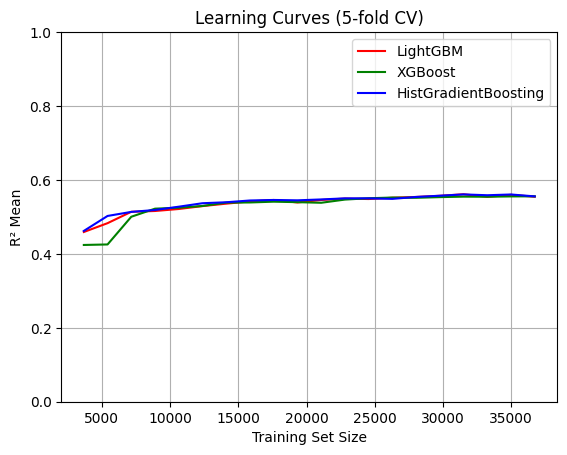

In [14]:
reg_estimators = {
    'LightGBM': LGBMRegressor(learning_rate=0.11, max_depth=6, n_estimators=150,
                              n_jobs=-1, verbose=-1),
    'XGBoost': XGBRegressor(learning_rate=0.11, max_depth=6, n_estimators=50,
                            n_jobs=-1),
    'HistGradientBoosting': HistGradientBoostingRegressor(learning_rate=0.11, max_depth=12)
}

plot_learning_curve(attributes=model_features, classes=model_classes,
                    estimators=reg_estimators, n_trainings=20)


- The learning curves of all the algorithms stagnate very early (at around 25% of the dataset size);
- It's necessary to investigate what's causing this premature stop, possibly rewinding and adding new steps on EDA and Preprocessing.



# **3. Feature selection and importances with tuned model**

In [15]:
from sklearn.feature_selection import RFECV
import seaborn as sns


def plot_selection_graph(rfecv: any) -> None:

    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Average R²")
    plt.ylim(0, 1)
    plt.errorbar(
        range(1, n_scores + 1),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Selection with CV")

    plt.savefig(f'{getcwd()}/../plots/feature_selection.svg', format='svg')
    plt.show()


def feature_selection(attributes: pd.DataFrame, classes: pd.DataFrame, cv_estimator: any) -> None:

    # Recursive feature selection with CV
    cv_selector = RFECV(estimator=cv_estimator, cv=5, step=1, scoring='r2',
                        verbose=False, n_jobs=-1)
    cv_selector = cv_selector.fit(attributes, classes)

    rfecv_mask = cv_selector.get_support()
    match_features = np.array(attributes.columns)
    selected_features = match_features[rfecv_mask]

    # Visualization
    plot_selection_graph(rfecv=cv_selector)
    print(f'\nOriginal number of features: {len(attributes.columns.values)}')
    print(f'Features: {list(attributes.columns.values)}\n')

    print(f'Optimal number of features: {cv_selector.n_features_}')
    print(f'Best features: {selected_features}')

    with open(f'{getcwd()}/../models/best_features.txt', 'w') as file:
        file.write(f'Optimal number of features: {cv_selector.n_features_}\n')
        file.write(f'Best features: {selected_features}')

    # Exports the feature selected dataset
    save_df = attributes.copy()
    save_df.drop(selected_features, axis='columns')
    save_df['Price'] = classes
    save_df.to_parquet(f'{getcwd()}/../datasets/feature_selected.parquet', index=False)



def plot_feature_importance(attributes: any, f_importances: any, alg_name: str) -> None:

    feature_dataframe = pd.DataFrame({'Feature': attributes, 'Feature Relevance': f_importances})

    feature_data = pd.DataFrame({'Feature': attributes, 'Feature Relevance': feature_dataframe['Feature Relevance']})
    feature_data = feature_data.sort_values(by='Feature Relevance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.title(f'Average Feature Importance ({alg_name})', fontsize=16)

    s = sns.barplot(y='Feature', x='Feature Relevance', data=feature_data, orient='h', palette='coolwarm')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)

    plt.savefig(f'{getcwd()}/../plots/feature_importance({alg_name}).svg', format='svg')
    plt.show()

- In a contradictory way observed in the EDA, (low correlation between _Price_ and _Days Available_) the _Days Available_ is one of the features with most predictive power;
- Another strange fact is that _Host ID_ is also an extremely relevant feature with this model. It's a feature with a high amount of unique values. This result maybe has a relationship with the equal frequency binning step applied to the feature, increasing the observable patterns, and thus, the predictive power;
- The features with an extreme low amount of unique values have the least predictive power. The larger the dataset is, features that have few unique values also won't present any relevant patterns, acting more like redundant information and not differentiating the instances.

<ipython-input-15-ed57143e875b>:67: UserWarning:

FixedFormatter should only be used together with FixedLocator



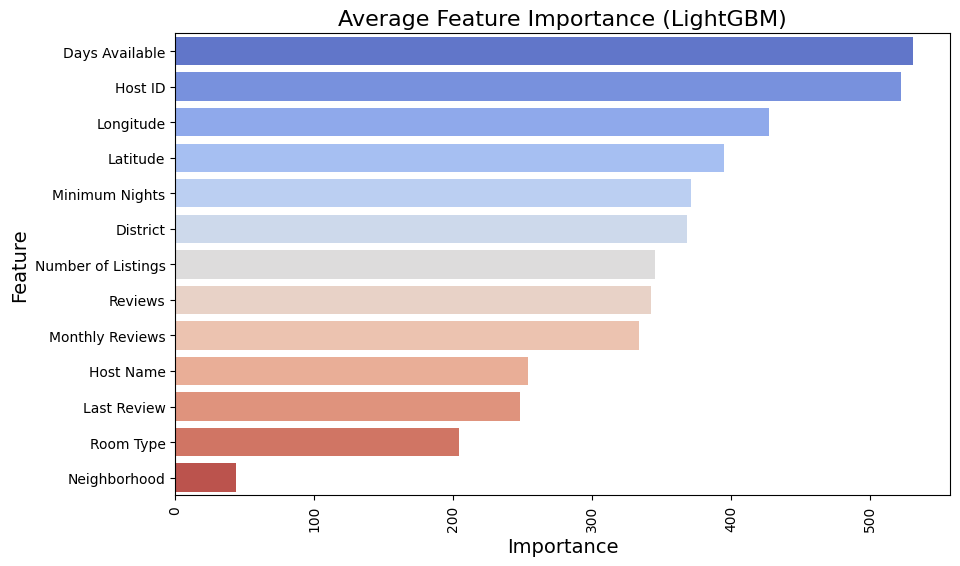

In [16]:
algorithm = LGBMRegressor(learning_rate=0.11, max_depth=6, n_estimators=150,
                          n_jobs=-1, verbose=-1)
algorithm.fit(model_features, model_classes)
plot_feature_importance(attributes=model_features.columns,
                        f_importances=algorithm.feature_importances_,
                        alg_name='LightGBM')

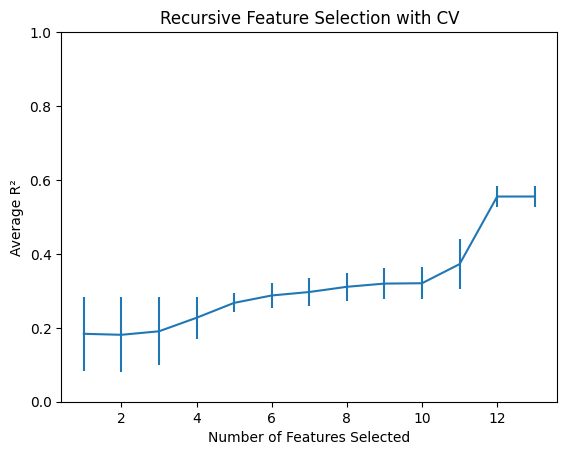


Original number of features: 13
Features: ['Host ID', 'Host Name', 'Neighborhood', 'District', 'Latitude', 'Longitude', 'Room Type', 'Minimum Nights', 'Reviews', 'Last Review', 'Monthly Reviews', 'Number of Listings', 'Days Available']

Optimal number of features: 13
Best features: ['Host ID' 'Host Name' 'Neighborhood' 'District' 'Latitude' 'Longitude'
 'Room Type' 'Minimum Nights' 'Reviews' 'Last Review' 'Monthly Reviews'
 'Number of Listings' 'Days Available']


In [17]:
feature_selection(attributes=model_features, classes=model_classes, cv_estimator=algorithm)

- Successful feature selection mostly reduces models' complexity and can improve its performance;
- Since features with low predictive power such as _Neighborhood_ weren't discarded, we conclude that this tuned model performs at its best with all the features;
- As a final evaluation, we have a LightGBM model with R² of approximately 0.58, which could be underperforming for this problem.

In [18]:
final_df = pd.read_parquet(f'{getcwd()}/../datasets/feature_selected.parquet')
final_features = final_df.drop(['Price'], axis='columns')
final_classes = final_df['Price']

final_scores = cross_validate(
    estimator=algorithm,
    X=final_features,
    y=final_classes,
    cv=KFold(n_splits=5, shuffle=True),
    scoring='r2',
    n_jobs=-1
)

r2_score = final_scores['test_score'].mean()
print(f'R²: {r2_score}')

R²: 0.5867406908911355


# **4. Statistical tests**

- With minimal differences in scoring, is to be expected that the models have some equivalence between them;
- _HistGradientBoosting_ is statistically equal to _XGBoost_ and _LightGBM_, although the latter are not statistically equal to each other;
- The standard deviation is a good provisory metric to analyze ML models statistical equivalence (low -> tends to be equal).

In [19]:
from mlxtend.evaluate import paired_ttest_5x2cv


def paired_ttest(model1, model2, attributes, classes):
    '''
    Significance level
    5% risk of concluding that a difference exists when there is no actual difference
    '''
    alpha = 0.05
    _, p = paired_ttest_5x2cv(model1, model2, attributes, classes)

    print(f'alpha:       {alpha}')
    print(f'p value:     {p}')

    if p > alpha:
        print('Models are statistically equal (Fail to reject null hypothesis)')
    else:
        print('Models are statistically different (Reject null hypothesis)')

In [20]:
regressor1 = LGBMRegressor(learning_rate=0.11, max_depth=6, n_estimators=150,
                           n_jobs=-1, verbose=-1)
regressor2 = XGBRegressor(learning_rate=0.11, max_depth=6,
                          n_estimators=50, n_jobs=-1)
regressor3 = HistGradientBoostingRegressor(learning_rate=0.11, max_depth=12)

In [21]:
print('LightGBM x XGBoost\n')
paired_ttest(regressor1, regressor2, model_features, model_classes)

LightGBM x XGBoost

alpha:       0.05
p value:     0.030960620428958273
Models are statistically different (Reject null hypothesis)


In [22]:
print('LightGBM x HistGradientBoosting\n')
paired_ttest(regressor1, regressor3, model_features, model_classes)

LightGBM x HistGradientBoosting

alpha:       0.05
p value:     0.05722683988126375
Models are statistically equal (Fail to reject null hypothesis)


In [23]:
print('XGBoost x HistGradientBoosting\n')
paired_ttest(regressor2, regressor3, model_features, model_classes)

XGBoost x HistGradientBoosting

alpha:       0.05
p value:     0.27540858588553824
Models are statistically equal (Fail to reject null hypothesis)


# **5. Training and saving final models**


In [24]:
import joblib

regressor1.fit(final_features, final_classes)
joblib.dump(regressor1, f'{getcwd()}/../models/lgbm_model.pkl')

regressor2.fit(final_features, final_classes)
joblib.dump(regressor2, f'{getcwd()}/../models/xgb_model.pkl')

regressor3.fit(final_features, final_classes)
joblib.dump(regressor3, f'{getcwd()}/../models/histgb_model.pkl')

['/content/../models/histgb_model.pkl']

# **6. Predicting a given instance**


In [25]:
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_float_dtype
from pandas.api.types import is_integer_dtype
import json


def discretize_values(df: pd.DataFrame, column: str) -> pd.DataFrame:

    filterwarnings('ignore')

    # Encodes entire columns of categorical data
    encoding = LabelEncoder()

    encoding.fit(df[column])
    df[column] = encoding.transform(df[column])

    return df


# First row of the original dataset
apt_data = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'price': 225,
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
    }

instance = pd.DataFrame([apt_data])

instance = instance.rename(columns={
    'id': 'ID',
    'nome': 'Name',
    'host_id': 'Host ID',
    'host_name': 'Host Name',
    'bairro_group': 'Neighborhood',
    'bairro': 'District',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'room_type': 'Room Type',
    'price': 'Price',
    'minimo_noites': 'Minimum Nights',
    'numero_de_reviews': 'Reviews',
    'ultima_review': 'Last Review',
    'reviews_por_mes': 'Monthly Reviews',
    'calculado_host_listings_count': 'Number of Listings',
    'disponibilidade_365': "Days Available"
})

# Preprocessing
instance = instance.drop(['ID', 'Name', 'Price'], axis='columns')

instance['Last Review'] = pd.to_datetime(instance['Last Review'])
instance['Last Review'] = instance['Last Review'].apply(lambda row: f'{str(row.year)}-{str(row.month)}')

for col in instance.columns.values:
    if not is_float_dtype(instance[col]) and not is_integer_dtype(instance[col]):
        instance = discretize_values(instance, col)

# Gets the binning threshold file generated in preprocessing
bins_file = "bins.json"
bins_id = '1eGRas7ZUyX6OOrihYfZUWrRYE9lqQ9L2'
gdown.download(f'https://drive.google.com/uc?id={bins_id}', bins_file)

with open(bins_file, 'r') as file:
    bins = json.load(file)

# Binning mapping
for feature in bins:
    binned_feature = np.digitize(instance[feature], bins[feature])
    instance[feature] = binned_feature

# Prediction
model = joblib.load(f'{getcwd()}/../models/lgbm_model.pkl')
prediction = model.predict(instance)
price = round(prediction[0], 2)
print(f'\n\nUS$ {str(price)}')

Downloading...
From: https://drive.google.com/uc?id=1eGRas7ZUyX6OOrihYfZUWrRYE9lqQ9L2
To: /content/bins.json
100%|██████████| 3.70k/3.70k [00:00<00:00, 8.43MB/s]



US$ 213.83


- According with the LightGBM model, the supposed apartment was evaluated with a price of US$ 213.83;
- For a single instance, that is a reasonable prediction, since it is approximately 5% lower than the ground truth (225);
- In this kind of problem, predicting lower is worse than higher, since it increases loss probability. For example, on a disease binary classification problem, a false positive is better than a false negative. Diagnosed as sick but in fact not be, is better than being diagnosed as healthy and having a disease.

# **7. Future Steps**

- Deeper analysis on prices per borough and neighborhood to be able to indicate the best purchase local with satisfactory level;
- Fine tuning with more parameters and more combinations;
- Play with feature (or instance) selection to reduce dataset size, computational cost and execution time without impacting negatively on model's performance;
- Explore NLP techniques with _Name_ column (possible feature engineering);
- Consider expanding the dataset with other sources.